# Clustering exploration

In [1]:
import altair as alt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import defaultdict

## load dfs from PCA file

In [3]:
dft_piv = pd.read_csv("../mat_save/dft_piv.tsv",sep='\t').fillna('')
mdf_piv = pd.read_csv("../mat_save/mdf_piv.tsv",sep='\t').fillna('')
mdf_piv_norm = pd.read_csv("../mat_save/mdf_piv_norm.tsv",sep='\t').fillna('')
mdf_piv_norm_nocu = pd.read_csv("../mat_save/mdf_piv_norm_nocu.tsv",sep='\t').fillna('')
mdf_piv_norm_nocu_subset = pd.read_csv("../mat_save/mdf_piv_norm_nocu_subset.tsv",sep='\t').fillna('')


In [4]:
mdf_piv.head()

,locus_tag,LanzaTech,MeOH,NO3_lowO2_slow_growth,NoCu,NoLanthanum,WT_control,WithLanthanum,aa3_KO,crotonic_acid,...,unknown,gene_symbol,product,type,sys,pc1,pc2,pc3,tsne1,tsne2
0,EQU24_RS00005,25.626702,23.323155,32.040358,44.338687,33.434023,34.988452,35.452185,26.849583,38.684021,...,20.462977,dnaA,chromosomal replication initiator protein DnaA,CDS,other,-0.242597,0.032800,0.007199,3.469032,10.165356
1,EQU24_RS00010,55.711920,18.905775,43.646760,59.619360,43.679839,38.272163,41.782237,45.489035,52.507256,...,20.753038,,DNA polymerase III subunit beta,CDS,other,-0.224666,0.028974,0.002134,-3.114132,9.638032
2,EQU24_RS00015,11.804042,18.443916,21.341623,28.258717,23.162675,15.495930,20.634554,11.962099,33.132559,...,12.244885,recF,DNA replication/repair protein RecF,CDS,other,-0.259354,0.036802,0.009310,11.034661,5.924214
3,EQU24_RS00020,76.880335,18.257805,62.257687,56.808319,57.287047,54.855025,57.120166,55.846659,77.849631,...,29.602255,gyrB,DNA topoisomerase (ATP-hydrolyzing) subunit B,CDS,other,-0.215584,0.021422,0.007413,-2.505093,7.504429
4,EQU24_RS00025,43.737438,16.950643,41.674925,49.829406,42.357072,35.396786,34.248335,33.097353,49.837247,...,29.494437,,hypothetical protein,CDS,other,-0.236185,0.029925,0.006343,1.054558,8.750976


In [5]:
# establish list of samples and experiment conditions
coord_cols = ['pc1','pc2','pc3','tsne1','tsne2']
samples = list(dft_piv.drop(coord_cols,axis=1).select_dtypes(include=['float']).columns)
exp_conds = list(mdf_piv.drop(coord_cols,axis=1).select_dtypes(include=['float']).columns)
exp_subset = ['uMax','lowCH4','NoCu','lowCu','medCu','highCu','NO3_lowO2_slow_growth','highO2_slow_growth','lowO2_fast_growth','MeOH','NoLanthanum','WithLanthanum'] 

## K-means clustering and viz functions

In [8]:
def run_kmeans(df_orig,cols,k=20):
    # make of copy of the original df
    df = df_orig.copy(deep=True)
    
    # kmean object
    km = KMeans(
        n_clusters=k, init='random',
        n_init=10, max_iter=300, 
        tol=1e-04, random_state=0
    )

    scaler = StandardScaler()
    X = scaler.fit_transform(df[cols])

    y_km = km.fit_predict(X)
    

    df['cluster_id'] = y_km
    print(df.shape)
    
    return df,X

# count the number of genes per cluster
def count_clusters(clust_df):
    clusters = defaultdict(list)
    for i,row in clust_df.iterrows():
        clusters[row['cluster_id']].append(row['locus_tag'])

    clust_counts = []
    for c in clusters:
        clust_counts.append((c,len(clusters[c])))
    
    return clusters,clust_counts

def view_cluster_counts(clust_counts):
    clustdf = pd.DataFrame(clust_counts, 
              columns=["cluster","count"])

    sns.barplot(data=clustdf, x='cluster',y='count',palette='hls')
    plt.show()
#     return alt.Chart(clustdf
#              ).mark_bar().encode(
#         x='cluster:O',
#         y='count:Q'
#     )

def alt_3pcs_tsne(df,fname):
    '''
    Given a df with cluster ids and pcs, visualize pcs 1,2,3 with clusters colored
    '''
    def pc_chart(x,y,pc_title):
        sel = alt.selection_multi(fields=['cluster_id'], bind='legend')
        chart = alt.Chart(df,
                            title=f"{pc_title} (Genes)",
                            height=300,
                            width=300
                           ).mark_circle().encode(
            x=x,
            y=y,
            color=alt.Color('cluster_id:N',scale=alt.Scale(scheme='sinebow')),
            tooltip=['locus_tag:N', 'type:N','gene_symbol:N', 'product:N','sys:N','cluster_id:N'],
            opacity=alt.condition(sel, alt.value(1), alt.value(0.2)),
            size=alt.condition(sel, alt.value(200), alt.value(100)),
        ).add_selection(
            sel,
        ).interactive()
        
        return chart
    
    chart12 = pc_chart('pc1:Q', 'pc2:Q', 'PCA of PC 1 and 2')
    chart23 = pc_chart('pc2:Q', 'pc3:Q', 'PCA of PC 2 and 3')
    chart13 = pc_chart('pc1:Q', 'pc3:Q', 'PCA of PC 1 and 3')
    chart_tsne = pc_chart('tsne1:Q', 'tsne2:Q', 'TSNE')
    
#     display(chart12)
#     display(chart23)
#     display(chart13)
#     display(chart_tsne)
    chart12.save(f"../altair_out/clustered_{fname}_pc12.html")
    chart23.save(f"../altair_out/clustered_{fname}_pc23.html")
    chart13.save(f"../altair_out/clustered_{fname}_pc13.html")
    chart_tsne.save(f"../altair_out/clustered_{fname}_tsne.html")
    
def kmeans_bundle(df,cols,fname):
    df_clust, X = run_kmeans(df, cols)
    clusters, clust_counts = count_clusters(df_clust)
    view_cluster_counts(clust_counts)
    alt_3pcs_tsne(df_clust,fname)
    
    return df_clust, X, clusters, clust_counts
    

# NOTE: check "altair_out/" for altair viz! Or uncomment "display" `alt_3pcs_tsne()`

(4213, 109)


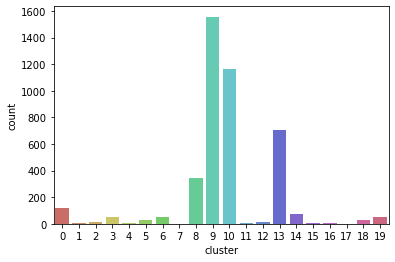

In [9]:
dft_piv_clust_df,\
dft_piv_clust_X, \
dft_piv_clusters,\
dft_piv_clust_counts = kmeans_bundle(dft_piv,samples,"genes_samp")

(4213, 30)


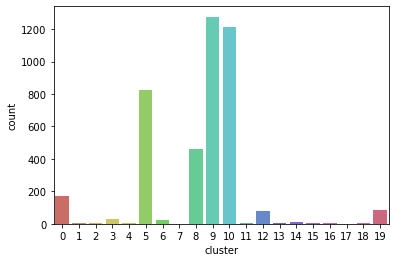

In [10]:
mdf_piv_clust_df,\
mdf_piv_clust_X, \
mdf_piv_clusters,\
mdf_piv_clust_counts = kmeans_bundle(mdf_piv,exp_conds,"genes_exp_ave")


(4213, 30)


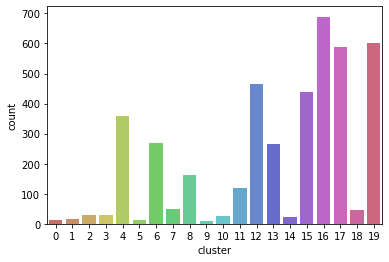

In [11]:
mdf_piv_norm_clust_df,\
mdf_piv_norm_clust_X, \
mdf_piv_norm_clusters,\
mdf_piv_norm_clust_counts = kmeans_bundle(mdf_piv_norm, exp_conds,"genes_exp_ave_norm")

(4213, 30)


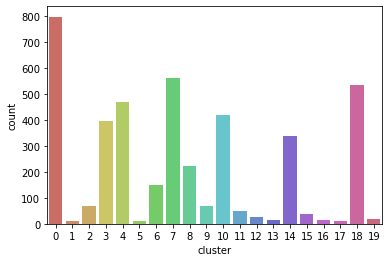

In [12]:
mdf_piv_norm_nocu_clust_df,\
mdf_piv_norm_nocu_clust_X, \
mdf_piv_norm_nocu_clusters,\
mdf_piv_norm_nocu_clust_counts = kmeans_bundle(mdf_piv_norm_nocu, exp_conds,"genes_exp_ave_norm_nocu")

(4213, 23)


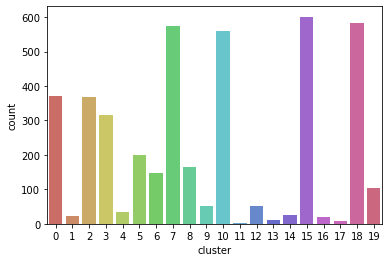

In [13]:
mdf_piv_norm_nocu_subset_clust_df,\
mdf_piv_norm_nocu_subset_clust_X, \
mdf_piv_norm_nocu_subset_clusters,\
mdf_piv_norm_nocu_subset_clust_counts = kmeans_bundle(mdf_piv_norm_nocu_subset, exp_subset,"genes_exp_ave_norm_nocu")

# Cluster expression visualizer!

In [14]:
def altair_pcoords(df,title,xorder='exp_condition_order'):
    # If more than 30 entries, make 2 columns
    col_num = 1 if len(df['locus_tag'].unique()) <=50 else 2
    
    highlight = alt.selection(type='single', on='mouseover',
                              fields=['desc_string'], nearest=True)
    
    selection = alt.selection_multi(fields=['desc_string'], bind='legend')


    base = alt.Chart(df.sort_values(xorder),
                     title=title
        ).encode(
        x=alt.X(f'{xorder}:N',
                sort=alt.EncodingSortField(field=f"{xorder}:N", op="count")
               ),
        y='mean:Q',
        color=alt.Color('desc_string:N',
                        legend=alt.Legend(title='Gene', 
                                          orient = 'right',
                                          labelLimit=0,
                                          columns=col_num,
                                          symbolLimit=200
                                         )),
        size=alt.value(100)        
    )
    

    lines = base.mark_line().encode(
        size=alt.condition((selection|highlight), alt.value(3), alt.value(1)),
        opacity=alt.condition((selection|highlight), alt.value(1), alt.value(0.5))
    ).add_selection(
        selection,
    ).properties(
         width=600,
         height=400
    ).interactive()
    
    
    points = base.mark_circle().encode(
        tooltip=['locus_tag','product','type','gene_symbol'],
        opacity=alt.condition((selection|highlight), alt.value(1), alt.value(0.2)),
        size=alt.condition((selection|highlight), alt.value(100), alt.value(3))
    ).add_selection(highlight)

    #return points + lines
    return lines + points

def check_cluster_expression(df, cols,cluster_id,title):
    df['desc_string'] = df.apply(lambda row: f"{row['locus_tag']}|{row['gene_symbol']}|{row['product']}",axis=1)
    id_vars = ['locus_tag','gene_symbol','product','type','sys','pc1','pc2','pc3','tsne1','tsne2','cluster_id','desc_string']
    dfm = df.melt(id_vars=id_vars, value_vars=cols,var_name='exp_condition',value_name="mean")
    # altair sort helper
    list_ordering = ['uMax','lowCH4','NoCu','lowCu','medCu','highCu','NO3_lowO2_slow_growth','highO2_slow_growth','lowO2_fast_growth','MeOH','NoLanthanum','WithLanthanum'] 
    dfm["exp_condition_order"] = pd.Categorical(dfm["exp_condition"], categories=list_ordering)
    #return dfm
    return altair_pcoords(dfm[dfm['cluster_id']==cluster_id],title)

In [15]:
check_cluster_expression(
    mdf_piv_norm_nocu_subset_clust_df, 
    exp_subset,
    13,
    "norm nocu subset, cluster 13")

alt.LayerChart(...)

# Other analyses
* Was 20 a good choice for k?
  * "elbow method"
  * silhouette analysis
  * Are clusters stable?
* Try other clustering methods
  * DBSCAN
* Filter out extremely low expression genes